In [153]:
%matplotlib ipympl

In [154]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import string
import pandas as pd

In [155]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [156]:
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    t12=R1/R2
    Rion1=R1
    Rion2=R2
    wclin1=1/(Rion1*Q)
    wclin2=1/(Rion2*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    S2=np.sqrt((1j*omega)**alpha/wclin2)
    
    Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNewzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)
    Z=-2*R1*(np.exp(2*S)+1)**2/((eps*(S**2+1/2)*np.exp(2*S)+(-S-(1/4)*eps)*np.exp(4*S)+S-(1/4)*eps))

    return Z
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNewzertSecond(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)

    Z=2*R1*4*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(-4*S**3-S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(-4*S**3-S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2+S*eps+4*S**2)*np.exp(6*S)-4*S**2+S*eps+(1/8)*eps**2))
    
    return Z



In [157]:
def plotter_for_ilin(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)

    p0=c0.initial_guess
    R1_0=p0[0]
    R2_0=p0[1]
    Q_0=p0[2]
    alpha_0=p0[3]

    pg=cg1.initial_guess
    R1_g=pg[0]
    R2_g=pg[1]
    Q_g=pg[2]
    alpha_g=pg[3]   

    pf1=cg1.parameters_
    print("pf1",pf1)
    R1_f1=pf1[0]
    R2_f1=pf1[1]
    Q_f1=pf1[2]
    alpha_f1=pf1[3]


    pf2=cg2.parameters_
    print("pf2",pf2)
    R1_f2=pf2[0]
    R2_f2=pf2[1]
    Q_f2=pf2[2]
    alpha_f2=pf2[3]

    pf3=cf3.parameters_
    R1_f3=pf3[0]
    R2_f3=pf3[1]
    Q_f3=pf3[2]
    alpha_f3=pf3[3]

    linewidth=1
    linewidth_actual=1
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    #ax1= fig.add_subplot(2,4,1)
    def give_ilin_R(r1,r2,delta):
        return 1/(1/r1+(1/r2-1/r1)*delta)
    
    dlt=np.linspace(0,1,50)
    Rf1=give_ilin_R(R1_f1,R2_f1,dlt)
    ax1.plot(dlt,give_ilin_R(R1_f1,R2_f1,dlt),linewidth=linewidth,color=color_fitted1,label="Fitted 1")
    ax1.plot(dlt,give_ilin_R(R1_f2,R2_f2,dlt),linewidth=linewidth,color=color_fitted2,label="Fitted 2")
    ax1.plot(dlt,give_ilin_R(R1_f3,R2_f3,dlt),linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.plot(dlt,give_ilin_R(R1_0,R2_0,dlt),linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.tick_params(labelsize=ticksize)
    ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    ax1.grid(visible=True)
    # ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    # ax1.axvline(x=delta_f1,ls="--",linewidth=0.6,color=color_fitted1)
    # ax1.axvline(x=delta_f2,ls="--",linewidth=0.6,color=color_fitted2)
    # ax1.axvline(x=delta_f3,ls="--",linewidth=0.6,color=color_fitted3)
    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    leg=ax1.legend()
    for line in leg.get_lines():
        line.set_linewidth(3)

    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #ax2.grid(visible=False)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(R1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)

    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    ax3a.clear()

    
    #print(np.angle(z0,deg=True))
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2,zf3))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    angle_z1=-np.angle(zf1,deg=True)
    angle_z2=-np.angle(zf2,deg=True)
    angle_z3=-np.angle(zf3,deg=True)
    
    print("dip_angle",dip_angle)
    ax3a.plot(freq,angle_z1,color=color_fitted1)
    ax3a.plot(freq,angle_z3,color=color_fitted2)
    ax3a.plot(freq,angle_z2,color=color_fitted3)
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=0.5)
    
    ax3a.set_xlabel("dv")
    ax3a.set_ylabel("dv")
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)
    # plot_bode(freq,zin1/factor,axes=[ax3a,],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    # plot_bode(freq,zin2/factor,axes=[ax3a,],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    # plot_bode(freq,zin3/factor,axes=[ax3a,],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    # plot_bode(freq,zf1/factor,axes=[ax3a,],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,zf2/factor,axes=[ax3a,],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,zf3/factor,axes=[ax3a,],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,z0/factor,axes=[ax3a,],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)


    percent_err1=(p0-pf1)*100/(p0)
    percent_err2=(p0-pf2)*100/(p0)
    percent_err3=(p0-pf3)*100/(p0)

    p0_table=[R1_0,R2_0,Q_0,alpha_0]
    pf1_table=[R1_f1,R2_f1,Q_f1,alpha_f1]
    pf2_table=[R1_f2,R2_f2,Q_f2,alpha_f2]
    pf3_table=[R1_f3,R2_f3,Q_f3,alpha_f3]
    pg_table=[R1_g,R2_g,Q_g,alpha_g]

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    percent_err_table3=percent_err3

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pg_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2,pf3_table,percent_err_table3])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1)
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Guess","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=[f"R1 [Ω]","R2 [Ω]","Q [Fs^(1-α)]","α"],loc="center") 
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(8)
    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Guess","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],index=["R1 [Ω]","R2 [Ω]","Q [Fs^(1-α)]","α"])

    with pd.ExcelWriter("gg.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)
    fig.savefig("gg.png",format="png",dpi=1000)



In [158]:
c0=CustomCircuit(initial_guess=[100,200,1e-4,0.99],circuit='TLMilinNew')
freq = np.logspace(3,-3,num=100)
z0 = c0.predict(freq)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [159]:
param_guess=[100,2000,1e-4,0.9]
cg1=CustomCircuit(initial_guess=param_guess,circuit='TLMilinNew')
cg2=CustomCircuit(initial_guess=param_guess,circuit='TLMilinNew')
cg3=CustomCircuit(initial_guess=param_guess,circuit='TLMilinNew')

z1=add_noise(z0,0.05)
z2=add_noise(z0,0.05)
z3=add_noise(z0,0.05)

C:\Users\admin\AppData\Local\Temp\ipykernel_400\3708065284.py:13: RuntimeWarning: invalid value encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
C:\Users\admin\AppData\Local\Temp\ipykernel_400\3708065284.py:13: RuntimeWarning: divide by zero encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
C:\Users\admin\AppData\Local\Temp\ipykernel

pf1 [9.69010725e+01 1.73920983e+02 1.01789902e-04 9.86714904e-01]
pf2 [9.78558477e+01 2.53159031e+02 1.01418780e-04 9.88846359e-01]
8.381403219285279
dip_angle 44.40217069198757


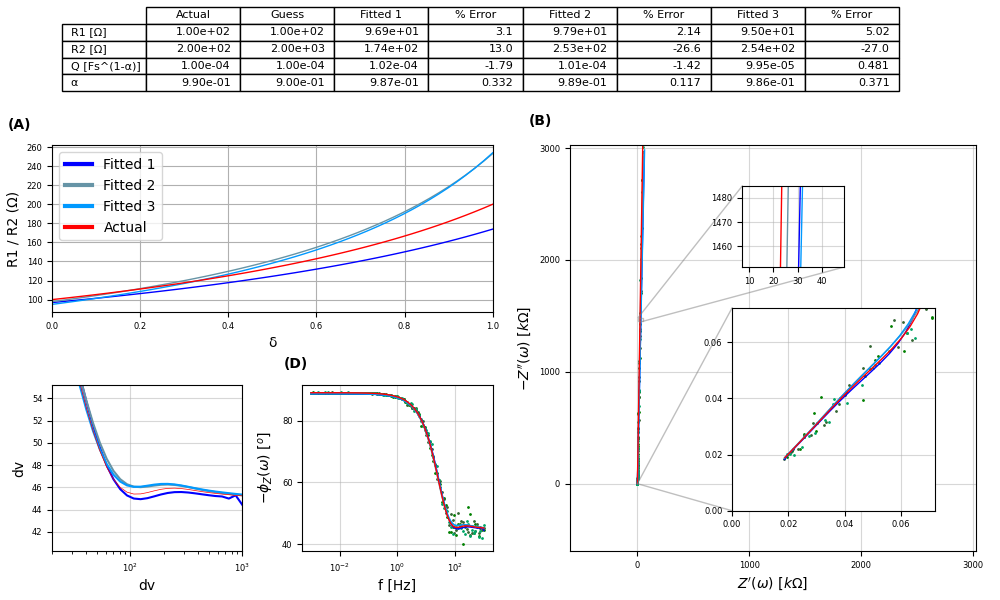

In [160]:
plotter_for_ilin(freq,circuit0=c0,zin1=z1,zin2=z2,zin3=z3,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,wt="mod")
plt.show()